In [1]:
from collections import defaultdict 
import statistics
import os
import sys
import csv
import math
import random
import time
import networkx as nx
from matplotlib.pyplot import figure
from networkx.algorithms.flow import edmonds_karp
from pathlib import Path, PureWindowsPath
import FordFulkerson as ff
import EdmondsKarp as EK
from multiprocessing import Pool
from collections import Counter
from IPython.display import Image, display
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

### classes 
are the labels of each node in the GrGs

In [2]:
classes = {"ACCESS_MASK":0,"Atom":1,"BOOLEAN":2,"Debug":3,"Device":4,
                                 "Environment":5,"File":6,"HANDLE":7,"Job":8,"LONG":9,"LPC":10,
                                 "Memory":11,"NTSTATUS":12,"Object":13,"Other":14,"PHANDLE":15,
                                 "PLARGE_INTEGER":16,"Process":17,"PUNICODE_STRING":18,
                                 "PULONG":19,"PULARGE_INTEGER":20,"PVOID_SIZEAFTER":21,
                                 "PWSTR":22,"Registry":23,"Security":24,"Synchronization":25,
                                 "Time":26,"Transaction":27,"ULONG":28,"WOW64":29, "DummyStart":30,"DummyEnd":31}

### createDirs(fold) 
creates lists of strings that contain the path to each graph file.

In [3]:
def createDirs(fold):
    path = "DATASET F1/fold_" +str(fold)
    mal_path = path+ "/20%_test"
    train_path = path+ "/80%_train"
    benign_path = "DATASET F1/specimen_benign/20%_test"
    
    w_mal_path = PureWindowsPath(mal_path)
    w_train_path= PureWindowsPath(train_path)
    w_benign_path = PureWindowsPath(benign_path)
#     print( mal_path+"\n"+ train_path+"\n"+ benign_path)
#     print( w_mal_path, w_train_path, w_benign_path)

    filename = "default_G_tone_map"
    mapFilename = "default_unique_mapping"
    
    rootDir = [os.path.join(root, name)
             for root, dirs, files in os.walk(w_mal_path)
             for name in files
             if name.endswith(filename+".csv")]
    rootDir.sort()
    # for i in range(len(paths)):
    #     p = [os.path.join(root, name)
    #              for root, dirs, files in os.walk(paths[i]+"/"+path)
    #              for name in files
    #              if name.endswith(filename+".csv")]
    #     p.sort()
    #     rootDirs[i] = p
    # print(rootDirs[10])
    benignDir = [os.path.join(root, name)
                 for root, dirs, files in os.walk(w_benign_path)
                 for name in files
                 if name.endswith(filename+".csv")]
    benignDir.sort()

    # for i in range(len(paths)):
    trainDir = [os.path.join(root, name)
                 for root, dirs, files in os.walk(w_train_path)
                 for name in files
                 if name.endswith(filename+".csv")]
    trainDir.sort()
    #     trainDirs[i] = trainDir
    return [rootDir,benignDir,trainDir]

### createGraphs(dirs,npmode)
imports the csv files and creates the nx.Graph() objects. Npmode returns numpy matrices of the graphs

In [4]:
def createGraphs(dirs,npmode):
    time_to = time.time()
    rootDir = dirs[0]
    benignDir = dirs[1]
    trainDir = dirs[2]
    mal_gs = []
    mal_np_gs = []
    ben_gs = []
    train_gs = []
    train_np_gs = []
    ben_np_gs = []
    csm_vals = {}
    for i in range(len(rootDir)):
        A = np.array(getArray(rootDir[i]))
        G = nx.from_numpy_matrix(A)
        mal_gs.append(G)
        mal_np_gs.append(A)
#         printProgressBar(i, len(rootDir)-1,prefix = 'malware gs')

    for i in range(len(trainDir)):
        A = np.array(getArray(trainDir[i]))
        G = nx.from_numpy_matrix(A)
        train_gs.append(G)
        train_np_gs.append(A)
#         printProgressBar(i, len(trainDir)-1, prefix = 'train gs')
        
    for i in range(len(benignDir)):
        A = np.array(getArray(benignDir[i]))
        G = nx.from_numpy_matrix(A)
        ben_gs.append(G)
        ben_np_gs.append(A)
#         printProgressBar(i, len(benignDir)-1, prefix = 'benign gs')
    if npmode:
        print(str(time.time()-time_to)+ "graph create TIME")
        return [mal_np_gs, ben_np_gs, train_np_gs]
    else: 
        print(str(time.time()-time_to)+ "graph create TIME")
        return [mal_gs, ben_gs, train_gs]

### getArray(path)
parses the csv file and returns a list with the contents of it.

In [5]:
def getArray (path):
    results = []
    with open(path) as csvfile:
        reader = csv.reader(csvfile,csv.QUOTE_NONNUMERIC) # change contents to floats
        for row in reader: # each row is a list
            nums = []
            for i in row: 
                if i :
                    nums.append(int(i))
            results.append(nums)
    return results

### def writeCSV()
generic method to quickly write a graph to a csv file.

In [6]:
def writeCSV(g,path,name):
    path_spl = path.split('/')
    path_spl[-1] = name
    sp_path = '/'.join(path_spl)
    with open(sp_path, mode='w') as cvg_file:
        cvg_writer = csv.writer(cvg_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for i in g:
            cvg_writer.writerow(i)

## Flow map
### def createFlowMap(g):
* Given the capacity of each edge and the neighbors of each node of a graph, the function returns a NxN array tha represents the flow map of the given graph, having in each `g'[i][j]= MaxFlow(cap,neighs,i,j)`. **the base function used to permutate our original GrGs** 

### def createMap(dirs):
* wrapper method that calls createFlowMap(path) for every path in the dirs list. This method is used to run through the rootDir, benignDir and train Dir to create our point of reference


In [7]:
def createFlowMap(capacity, neighbors): 
    values = [[0 for i in range(len(capacity))] for j in range(len(capacity))]

    for i in range(len(capacity)):
        for j in range(len(capacity)):
            values[i][j] = EK.EdmondsKarp(capacity,neighbors,i,j)
    return values

In [8]:
def createMap(paths):
    mal_paths = paths[0]
    benign_paths = paths[1]
    train_paths = paths[2]
    mals = {}
    bens = {}
    trains ={}
    mal_vals = []
    ben_vals = []
    train_vals = []
    
    for i in range(len(mal_paths)):
        cap, neig = EK.ParseGraph(mal_paths[i])
        mals[i]=[cap,neig]
        v = np.array(createFlowMap(cap,neig))
        x,y = v.shape
        mal_vals.append(np.reshape(v,x*y))
#         printProgressBar(i, len(mal_paths)-1, length = 50,prefix = "malware")       

    for i in range(len(benign_paths)):
        cap, neig = EK.ParseGraph(benign_paths[i])
        bens[i]=[cap,neig]
        v =np.array(createFlowMap(cap,neig))
        x,y = v.shape
        ben_vals.append(np.reshape(v,x*y))
#         printProgressBar(i, len(benign_paths)-1, length = 50,prefix = "benign")       

    for i in range(len(train_paths)):
        cap, neig = EK.ParseGraph(train_paths[i])
        trains[i]=[cap,neig]
        v = np.array(createFlowMap(cap,neig))
        x,y = v.shape
        train_vals.append(np.reshape(v,x*y))
#         printProgressBar(i, len(train_paths)-1, length = 50,prefix = "train")       
    
    
    return [mal_vals,ben_vals,train_vals]

### calcPageRank(Graphs)
calculates the pageRank values of the graphs.

In [9]:
def calcPageRank(graphs):
    mal = graphs[0]
    ben = graphs[1]
    train = graphs[2]
    
    pgr_mal = [nx.pagerank_numpy(nx.from_numpy_matrix(mal[i].reshape(30,30))) for i in range(len(mal))]
    pgr_ben = [nx.pagerank_numpy(nx.from_numpy_matrix(ben[i].reshape(30,30))) for i in range(len(ben))]
    pgr_train = [nx.pagerank_numpy(nx.from_numpy_matrix(train[i].reshape(30,30))) for i in range(len(train))]
    
    pgrgs = [list(pgr_mal[i].values()) for i in range(len(pgr_mal))]
    pgrgs_ben = [list(pgr_ben[i].values())for i in range(len(pgr_ben))]
    pgrgs_train = [list(pgr_train[i].values())for i in range(len(pgr_train))]
    
    return [pgrgs, pgrgs_ben, pgrgs_train]

### calculateDifference(listA,listB,dirs,isBenign,metric)
computes the similarity of each pair of test graphs with the train graphs, returning the pair with the maximum similarity

In [10]:
def calculateDifference(listA, listB, dirs,isBenign, metric = "csm"):
    ret_val = []
    rootDir = dirs[0]
    benDir = dirs[1]
    trainDir = dirs[2]
    methods = {'csm': lambda a,b : 1-distance.cosine(a,b), 
               'euc': lambda a,b: 1000.0/(1000.0+distance.euclidean(a,b)), 
               'bray': lambda a,b: 1-distance.braycurtis(a,b), 
               'mink': lambda a,b: 1000.0/(1000.0+distance.minkowski(a,b,1)),
               'prod': lambda a,b: (1-distance.cosine(a,b))*(1-distance.braycurtis(a,b)),
               'sqeuc' : lambda a,b: 1000.0/(1000.0+distance.sqeuclidean(a,b)),
               'cor' : lambda a,b: 1-distance.correlation(a,b)}
    for i in range(len(listA)):
#         printProgressBar(i,len(listA)-1, length = 50, prefix = 'diff calculation', suffix = "with " + metric)
        val = []
        e_val = []
        stats = []
        for j in range(len(listB)):
            val.append(methods[metric](listA[i], listB[j]))
        if isBenign:
            ret_val.append([benDir[i].split('\\')[-3],max(val),trainDir[val.index(max(val))].split('\\')[-3]])
        else :
            ret_val.append([rootDir[i].split('\\')[-3],max(val),trainDir[val.index(max(val))].split('\\')[-3]])
    return ret_val


### similarityMetric(sr)
calculates and returns the classification values.

In [11]:
def similarityMetric(sr):
    counterA = 0
    counterB = 0
    counterC = 0
    for i in sr :
        A,B = i[0].split(',')[0], i[0].split(',')[1]
        C,D = i[2].split(',')[0], i[2].split(',')[1]
        if A==C and B==D:
            counterA +=1
        if A==C or B==D:
            counterB +=1
        if A==C or A==D or B == C or B == D:
            counterC += 1
#     print("cA = %d (%f) cB= %d (%f) cC =%d (%f)"%(counterA, counterA/len(sr), counterB, counterB/len(sr), counterC, counterC/len(sr)))
    return [counterA/len(sr),counterB/len(sr),counterC/len(sr)]

### saveFigures(mal_th,ben_th,start,iteration)
creates and saves the figures of our experiments using matplotlib

In [12]:
def saveFigures(mal_th, ben_th, start, iteration):
    lists = [mal_th,ben_th]
    diffs = []
    v = 0
    for i in range(len(mal_th)):
        v = max(v,abs(mal_th[i]-ben_th[i]))
        diffs.append(abs(mal_th[i]-ben_th[i]))
#     print(v)
    d = max(diffs)
#     print(d, mal_th[diffs.index(d)])

    for i in lists:
        plt.plot(i,marker= 11)
    plt.title("max dif at %f"%(diffs[diffs.index(d)]))
    plt.legend(["True positives","False positives"])
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0,step, 1))
    plt.ylabel("")
    plt.draw()
    try:
        os.mkdir(str(iteration))
    except OSError:
#         print ("Creation of the directory %s failed" % str(iteration))
        pass
    else:
        print ("Successfully created the directory %s" % str(iteration))
    plt.savefig(str(iteration)+"/"+str(start)+".png")
    plt.clf()

### detection
creates the graphics taking into account the `step` and the `threshold`
### detectionSteps
calculates the Five-Fold-Average of all experiments.

In [13]:
def detectSteps(testA, testB,step, metric = "Csm"):
    detect = []
    thresh = []
    for i in range(len(testA)):
        det, thr = detection(testA[i], testB[i], i, step, metric=metric)
        detect.append(det)
        thresh.append(thr)
    return detect, thresh

In [14]:
def detection(ben, mal, itr, step, metric = 'Csm' ):
    thresh = np.arange(ben[-1], ben[0], abs(ben[0]-ben[-1])/step)
    thresh = np.append(thresh, ben[0])
    m = np.array((sum(i > thresh for i in mal)/len(mal))*100)
    p = np.array((sum(i > thresh for i in ben)/len(ben))*100)
    for i in [m,p]:
        plt.plot(i)
    plt.yticks(np.arange(0,100,5))
    plt.xticks(np.arange(0,len(thresh),1))
    plt.draw()
    plt.title('detection at '+str(itr)+ ' iteration')
    plt.savefig(metric+"--"+ str(itr)+'--flow.png')
    plt.clf()
    return [m, p], thresh

In [15]:
def sortTests(test):
    sortedTests =[]
    for i in range(len(test)):
        srTest = sorted(test[i], key = lambda kv:kv[1],reverse = True)
        sortedTests.append(srTest)
    return sortedTests

### simAverages
Calculates and prints the classification Five-Fold-Averages

In [46]:
def simAverages(malTest, benTest, metric):
    similarities = [similarityMetric(malTest[i]) for i in range(len(malTest))]
    for i in similarities :
        print(i)
    counts = [[i[j] for i in similarities] for j in range(len(i))]
    avg = [statistics.mean(i) for i in counts]
    print("---------------")
    print(metric)
    print("---------------")
    print(avg)

In [17]:
def plot_metrics(listA, listB, listThr, metric):
    diffs = []
    v = 0
    for i in range(len(listA)):
        v = max(v,abs(listA[i]-listB[i]))
        diffs.append(abs(listA[i]-listB[i]))
    pd = diffs.index(v)
    print(listA[pd], listB[pd])
    figure(num=None, figsize=(10,7), dpi=200, facecolor='w', edgecolor=None)
    plt.margins(0.01)
    plt.plot(listA,'r')
    plt.plot(listB,'g')
#     plt.plot(pd,listA[pd],'yo-')
#     plt.plot(pd,listB[pd],'yo-')
#     plt.plot((pd,pd),(listA[pd],listB[pd]),'k--')
    xi = list(range(len(listThr)))
    plt.xticks(xi,[round(i,5) for i in listThr])
    plt.xticks(fontsize=8, rotation=90)
    plt.yticks(np.arange(0,105,5))
    plt.legend(["TP-rate","FP-rate"], loc='lower left')
#     plt.title("Average five fold with %s metric"%(metric))
    plt.savefig("Average five fold with %s metric"%(metric))
    plt.clf()

**itDirs** holds the paths to all graphs five-fold.

**maps** holds the flowMaps of all graphs five-fold

In [18]:
itDirs = [createDirs(i) for i in range(1,6)]

maps = [createMap(itDirs[i]) for i in range(len(itDirs))]

**pgrMap** holds the pageRank vectors for all graphs five-fold

In [19]:
pgrMap = [calcPageRank(maps[i]) for i in range(len(maps))]

In [20]:
t = time.time()
malwareTests = [calculateDifference(maps[i][0],maps[i][2], 
                                    itDirs[i], False) for i in range(len(maps))]
print("malware took %f seconds"%(time.time()-t))

benignTests = [calculateDifference(maps[i][1],maps[i][2], 
                                   itDirs[i], True) for i in range(len(maps))]


malware took 180.882434 seconds


In [21]:
sortBenignTests= sortTests(benignTests)

sortMalwareTests =  sortTests(malwareTests)

In [22]:
malwares =  [[sortMalwareTests[j][i][1] for i in range(len(sortMalwareTests[j]))] 
             for j in range(len(sortMalwareTests))]
benigns =  [[sortBenignTests[j][i][1] for i in range(len(sortBenignTests[j]))] 
             for j in range(len(sortBenignTests))]

In [23]:
t = time.time()
malwareTestsEuc = [calculateDifference(maps[i][0],maps[i][2], 
                                    itDirs[i], False, metric = "euc") for i in range(len(maps))]
print("malware took %f seconds"%(time.time()-t))

benignTestsEuc = [calculateDifference(maps[i][1],maps[i][2], 
                                   itDirs[i], True, metric = "euc") for i in range(len(maps))]

malware took 64.560405 seconds


In [24]:
sortBenignTestsEuc = sortTests(benignTestsEuc)
sortMalwareTestsEuc = sortTests(malwareTestsEuc)

In [25]:
malwaresEuc =  [[sortMalwareTestsEuc[j][i][1] for i in range(len(sortMalwareTestsEuc[j]))] 
             for j in range(len(sortMalwareTestsEuc))]

benignsEuc =  [[sortBenignTestsEuc[j][i][1] for i in range(len(sortBenignTestsEuc[j]))] 
             for j in range(len(sortBenignTestsEuc))]



In [26]:
t = time.time()
malwareTestsBray = [calculateDifference(maps[i][0],maps[i][2], 
                                    itDirs[i], False, metric = "bray") for i in range(len(maps))]
print("malware euc took %f seconds"%(time.time()-t))

benignTestsBray = [calculateDifference(maps[i][1],maps[i][2], 
                                   itDirs[i], True, metric = "bray") for i in range(len(maps))]

malware euc took 87.747525 seconds


In [27]:
sortBenignTestsBray = sortTests(benignTestsBray)
sortMalwareTestsBray = sortTests(malwareTestsBray)

In [28]:
malwaresBray =  [[sortMalwareTestsBray[j][i][1] for i in range(len(sortMalwareTestsBray[j]))] 
             for j in range(len(sortMalwareTestsBray))]

benignsBray =  [[sortBenignTestsBray[j][i][1] for i in range(len(sortBenignTestsBray[j]))] 
             for j in range(len(sortBenignTestsBray))]



In [29]:
t = time.time()
malwareTestsSq = [calculateDifference(maps[i][0],maps[i][2], 
                                    itDirs[i], False, metric = "sqeuc") for i in range(len(maps))]
print("malware took %f seconds"%(time.time()-t))

benignTestsSq = [calculateDifference(maps[i][1],maps[i][2], 
                                   itDirs[i], True, metric = "sqeuc") for i in range(len(maps))]

malware took 61.102649 seconds


In [30]:
sortBenignTestsSq = sortTests(benignTestsSq)
sortMalwareTestsSq = sortTests(malwareTestsSq)

In [31]:
malwaresSq =  [[sortMalwareTestsSq[j][i][1] for i in range(len(sortMalwareTestsSq[j]))] 
             for j in range(len(sortMalwareTestsSq))]

benignsSq =  [[sortBenignTestsSq[j][i][1] for i in range(len(sortBenignTestsSq[j]))] 
             for j in range(len(sortBenignTestsSq))]



In [32]:
# t = time.time()
# malwareTestsCor = [calculateDifference(maps[i][0],maps[i][2], 
#                                     itDirs[i], False, metric = "cor") for i in range(len(maps))]
# print("malware took %f seconds"%(time.time()-t))

# benignTestsCor = [calculateDifference(maps[i][1],maps[i][2], 
#                                    itDirs[i], True, metric = "cor") for i in range(len(maps))]

malware took 259.619942 seconds


In [33]:
sortBenignTestsCor = sortTests(benignTestsCor)
sortMalwareTestsCor = sortTests(malwareTestsCor)

In [34]:
malwaresCor =  [[sortMalwareTestsCor[j][i][1] for i in range(len(sortMalwareTestsCor[j]))] 
             for j in range(len(sortMalwareTestsCor))]

benignsCor =  [[sortBenignTestsCor[j][i][1] for i in range(len(sortBenignTestsCor[j]))] 
             for j in range(len(sortBenignTestsCor))]



In [38]:
t = time.time()
malwareTestsProd = [calculateDifference(maps[i][0],maps[i][2], 
                                    itDirs[i], False, metric = "prod") for i in range(len(maps))]
print("malware took %f seconds"%(time.time()-t))

benignTestsProd = [calculateDifference(maps[i][1],maps[i][2], 
                                   itDirs[i], True, metric = "prod") for i in range(len(maps))]
sortBenignTestsProd = sortTests(benignTestsProd)
sortMalwareTestsProd = sortTests(malwareTestsProd)

malware took 270.394490 seconds


In [39]:
malwaresProd =  [[sortMalwareTestsProd[j][i][1] for i in range(len(sortMalwareTestsProd[j]))] 
             for j in range(len(sortMalwareTestsProd))]

benignsProd =  [[sortBenignTestsProd[j][i][1] for i in range(len(sortBenignTestsProd[j]))] 
             for j in range(len(sortBenignTestsProd))]



In [40]:
t = time.time()
malwareTestsMin = [calculateDifference(maps[i][0],maps[i][2], 
                                    itDirs[i], False, metric = "mink") for i in range(len(maps))]
print("malware took %f seconds"%(time.time()-t))

benignTestsMin = [calculateDifference(maps[i][1],maps[i][2], 
                                   itDirs[i], True, metric = "mink") for i in range(len(maps))]
sortBenignTestsMin = sortTests(benignTestsMin)
sortMalwareTestsMin = sortTests(malwareTestsMin)

malware took 64.233487 seconds


In [41]:
malwaresMin =  [[sortMalwareTestsMin[j][i][1] for i in range(len(sortMalwareTestsMin[j]))] 
             for j in range(len(sortMalwareTestsMin))]

benignsMin =  [[sortBenignTestsMin[j][i][1] for i in range(len(sortBenignTestsMin[j]))] 
             for j in range(len(sortBenignTestsMin))]



In [42]:
steps = 20
detect, csmThresh = detectSteps(benigns,malwares,steps, metric= "Csm")
detectEuc, eucThresh = detectSteps(benignsEuc,malwaresEuc, steps, metric="Euc")
detectBray, brayThresh = detectSteps(benignsBray,malwaresBray, steps, metric="Bray")
detectSq, sqThresh = detectSteps(benignsSq,malwaresSq, steps, metric="Sqeuc")
detectCor, corThresh = detectSteps(benignsCor, malwaresCor, steps, metric="Dist Cor")
detectProd, prodThresh = detectSteps(benignsProd, malwaresProd, steps, metric="Prod")
detectMin, minThresh = detectSteps(benignsMin, malwaresMin, steps, metric="Minkowski")

<Figure size 432x288 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

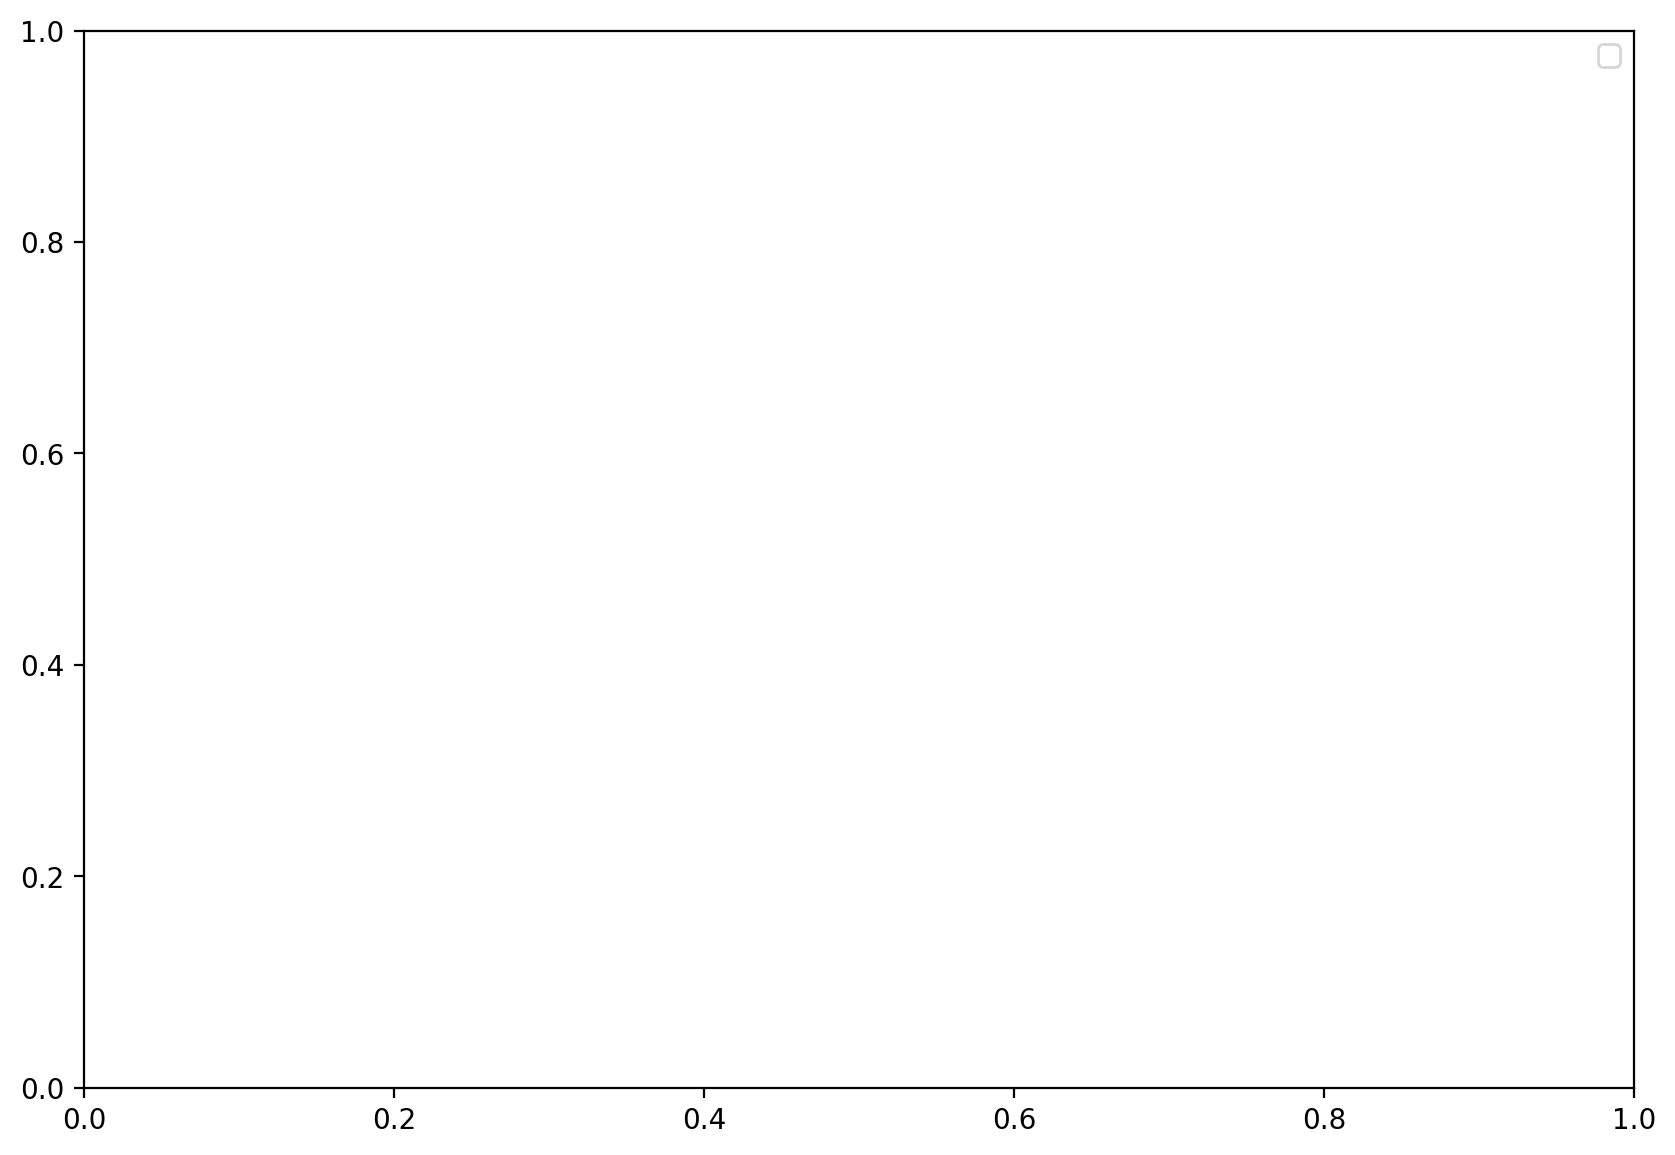

In [43]:
mal_det = np.array([detect[i][0] for i in range(len(detect))])
ben_det = np.array([detect[i][1] for i in range(len(detect))])
threshMean_csm = np.mean(np.array([i for i in csmThresh]),axis=0)

mal_euc = np.array([detectEuc[i][0] for i in range(len(detectEuc))])
ben_euc = np.array([detectEuc[i][1] for i in range(len(detectEuc))])
threshMean_euc = np.mean(np.array([i for i in eucThresh]),axis=0)

mal_bray = np.array([detectBray[i][0] for i in range(len(detectBray))])
ben_bray = np.array([detectBray[i][1] for i in range(len(detectBray))])
threshMean_bray = np.mean(np.array([i for i in brayThresh]),axis=0)

mal_sq = np.array([detectSq[i][0] for i in range(len(detectSq))])
ben_sq = np.array([detectSq[i][1] for i in range(len(detectSq))])
threshMean_sq = np.mean(np.array([i for i in sqThresh]),axis=0)

mal_cor = np.array([detectCor[i][0] for i in range(len(detectCor))])
ben_cor = np.array([detectCor[i][1] for i in range(len(detectCor))])
threshMean_cor = np.mean(np.array([i for i in corThresh]),axis=0)

mal_prod = np.array([detectProd[i][0] for i in range(len(detectProd))])
ben_prod = np.array([detectProd[i][1] for i in range(len(detectProd))])
threshMean_prod = np.mean(np.array([i for i in prodThresh]),axis=0)

mal_min = np.array([detectMin[i][0] for i in range(len(detectMin))])
ben_min = np.array([detectMin[i][1] for i in range(len(detectMin))])
threshMean_min = np.mean(np.array([i for i in minThresh]),axis=0)

avg_det = np.mean(mal_det,axis=0)
avg_det_b = np.mean(ben_det,axis=0)
avg_euc = np.mean(mal_euc, axis =0)
avg_euc_b = np.mean(ben_euc,axis = 0)
avg_bray = np.mean(mal_bray, axis =0)
avg_bray_b = np.mean(ben_bray,axis = 0)
avg_sq = np.mean(mal_sq, axis =0)
avg_sqeuc_b = np.mean(ben_sq,axis = 0)
avg_cor = np.mean(mal_cor, axis =0)
avg_cor_b = np.mean(ben_cor,axis = 0)
avg_prod = np.mean(mal_prod, axis =0)
avg_prod_b = np.mean(ben_prod,axis = 0)
avg_min = np.mean(mal_min, axis =0)
avg_min_b = np.mean(ben_min,axis = 0)

tot_avg = np.mean(np.array([avg_det,avg_euc,avg_bray,avg_min,avg_cor]),axis=0)
tot_avg_b = np.mean(np.array([avg_det_b,avg_euc_b,avg_bray_b,avg_min_b,avg_cor_b]),axis=0)

figure(num=None, figsize=(10,7), dpi=200, facecolor='w', edgecolor='k')
plt.margins(0.01)
plt.xticks(np.arange(0,len(avg_det),1))
plt.yticks(np.arange(0,105,5))
# plt.title("Average Metrics Flow Map")
plt.plot(avg_det)
plt.plot(avg_euc)
plt.plot(avg_bray)
plt.plot(avg_sq)
plt.plot(avg_cor)
plt.plot(avg_prod)
plt.plot(avg_min)
plt.legend(['cosine', 'euclidean','bray-curtis', 'squared euclidean', 'correlation', 'product', 'minkowski'], loc = 'lower left')
plt.savefig("Average Malware of all metrics.png")
plt.clf()
figure(num=None, figsize=(10,7), dpi=200, facecolor='w', edgecolor='k')
plt.margins(0.01)
plt.xticks(np.arange(0,len(avg_det),1))
plt.yticks(np.arange(0,105,5))
plt.plot(avg_det_b)
plt.plot(avg_euc_b)
plt.plot(avg_bray_b)
plt.plot(avg_sqeuc_b)
plt.plot(avg_cor_b)
plt.plot(avg_prod_b)
plt.plot(avg_min_b)
plt.legend(['cosine', 'euclidean','bray-curtis', 'squared euclidean', 'correlation', 'product', 'minkowski'], loc = 'lower left')

plt.savefig("Average Benign of all metrics")
plt.clf()
# x = [round(i,1) for i in avg_det]
# # plt.plot((avg_euc+avg_bray)/2)
# # plt.plot((avg_euc_b + avg_bray_b)/2)
# xi = list(range(len(x)))
# plt.xticks(xi, x)

# plt.xlabel(avg_det)
# plt.xticks(np.arange(0,len(avg_det),1))
# plt.yticks(np.arange(0,105,5))
plt.legend(["cosine malware", "cosine benign","euclidean malware", "euclidean benign", "BC malware", 
            "BC benign", "Mink malware", "Mink benign"])
# plt.savefig("averages of all metrics.png")

In [44]:
plot_metrics(avg_det,avg_det_b,threshMean_csm,"cosine")
plot_metrics(avg_euc,avg_euc_b,threshMean_euc,"euclidean")
plot_metrics(avg_bray,avg_bray_b,threshMean_bray,"bray-curtis")
plot_metrics(avg_min,avg_min_b,threshMean_min,"minkowski")
plot_metrics(avg_cor, avg_cor_b,threshMean_cor, "correlation")
plot_metrics(avg_sq, avg_sqeuc_b,threshMean_sq, "square euc")

86.18325236113479 0.0
90.27970784698613 10.285714285714286
87.48088777942665 0.0
90.62461675779818 10.857142857142858
86.1448646452039 0.0
89.4363391616384 8.571428571428571


<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

In [47]:
simAverages(sortMalwareTests,sortBenignTests,"Csm")
print("===========================================")
print()
simAverages(sortMalwareTestsEuc,sortBenignTestsEuc,"Euc")
print("===========================================")
print()
simAverages(sortMalwareTestsBray,sortBenignTestsBray,"Bray")
print("===========================================")
print()
simAverages(sortMalwareTestsSq,sortBenignTestsSq,"Sq")
print("===========================================")
print()
simAverages(sortMalwareTestsCor,sortBenignTestsCor,"Cor")
print("===========================================")
print()
simAverages(sortMalwareTestsProd,sortBenignTestsProd,"Prod")
print("===========================================")
simAverages(sortMalwareTestsMin,sortBenignTestsMin,"Minkowski")


[0.6641074856046065, 0.8061420345489443, 0.8157389635316699]
[0.6641074856046065, 0.8042226487523992, 0.817658349328215]
[0.6583493282149712, 0.7965451055662188, 0.8157389635316699]
[0.6525911708253359, 0.7907869481765835, 0.8195777351247601]
[0.6275992438563327, 0.782608695652174, 0.7996219281663516]
---------------
Csm
---------------
[0.6533509428211706, 0.796061086539264, 0.8136671879365333]

[0.654510556621881, 0.7888675623800384, 0.8042226487523992]
[0.6429942418426103, 0.7869481765834933, 0.8023032629558541]
[0.6525911708253359, 0.7907869481765835, 0.8080614203454894]
[0.6506717850287908, 0.781190019193858, 0.8023032629558541]
[0.6200378071833649, 0.7674858223062382, 0.782608695652174]
---------------
Euc
---------------
[0.6441611123003965, 0.7830557057280423, 0.7998998581323542]

[0.6756238003838771, 0.8214971209213052, 0.8310940499040307]
[0.6641074856046065, 0.8042226487523992, 0.8214971209213052]
[0.6583493282149712, 0.800383877159309, 0.8195777351247601]
[0.656429942418426

In [48]:
t = time.time()
malwareTestsPrank = [calculateDifference(pgrMap[i][0],pgrMap[i][2], 
                                    itDirs[i], False) for i in range(len(pgrMap))]
print("malware took %f seconds"%(time.time()-t))

benignTestsPrank = [calculateDifference(pgrMap[i][1],pgrMap[i][2], 
                                   itDirs[i], True) for i in range(len(pgrMap))]
sortBenignTestsPrank = sortTests(benignTestsPrank)
sortMalwareTestsPrank = sortTests(malwareTestsPrank)
malwaresPrank =  [[sortMalwareTestsPrank[j][i][1] for i in range(len(sortMalwareTestsPrank[j]))] 
             for j in range(len(sortMalwareTestsPrank))]

benignsPrank =  [[sortBenignTestsPrank[j][i][1] for i in range(len(sortBenignTestsPrank[j]))] 
             for j in range(len(sortBenignTestsPrank))]



malware took 146.201767 seconds


In [49]:
t = time.time()
malwareTestsPrankEuc = [calculateDifference(pgrMap[i][0],pgrMap[i][2], 
                                    itDirs[i], False, metric = 'euc') for i in range(len(pgrMap))]
print("malware took %f seconds"%(time.time()-t))

benignTestsPrankEuc = [calculateDifference(pgrMap[i][1],pgrMap[i][2], 
                                   itDirs[i], True, metric = 'euc') for i in range(len(pgrMap))]
sortBenignTestsPrankEuc = sortTests(benignTestsPrankEuc)
sortMalwareTestsPrankEuc = sortTests(malwareTestsPrankEuc)
malwaresPrankEuc =  [[sortMalwareTestsPrankEuc[j][i][1] for i in range(len(sortMalwareTestsPrankEuc[j]))] 
             for j in range(len(sortMalwareTestsPrankEuc))]

benignsPrankEuc =  [[sortBenignTestsPrankEuc[j][i][1] for i in range(len(sortBenignTestsPrankEuc[j]))] 
             for j in range(len(sortBenignTestsPrankEuc))]



malware took 63.028886 seconds


In [50]:
t = time.time()
malwareTestsPrankBray = [calculateDifference(pgrMap[i][0],pgrMap[i][2], 
                                    itDirs[i], False, metric = 'bray') for i in range(len(pgrMap))]
print("malware took %f seconds"%(time.time()-t))

benignTestsPrankBray = [calculateDifference(pgrMap[i][1],pgrMap[i][2], 
                                   itDirs[i], True, metric = 'bray') for i in range(len(pgrMap))]
sortBenignTestsPrankBray = sortTests(benignTestsPrankBray)
sortMalwareTestsPrankBray = sortTests(malwareTestsPrankBray)
malwaresPrankBray =  [[sortMalwareTestsPrankBray[j][i][1] for i in range(len(sortMalwareTestsPrankBray[j]))] 
             for j in range(len(sortMalwareTestsPrankBray))]

benignsPrankBray =  [[sortBenignTestsPrankBray[j][i][1] for i in range(len(sortBenignTestsPrankBray[j]))] 
             for j in range(len(sortBenignTestsPrankBray))]



malware took 71.835955 seconds


In [51]:
t = time.time()
malwareTestsPrankSqeuc = [calculateDifference(pgrMap[i][0],pgrMap[i][2], 
                                    itDirs[i], False,metric= 'sqeuc') for i in range(len(pgrMap))]
print("malware took %f seconds"%(time.time()-t))

benignTestsPrankSqeuc = [calculateDifference(pgrMap[i][1],pgrMap[i][2], 
                                   itDirs[i], True, metric = 'sqeuc') for i in range(len(pgrMap))]
sortBenignTestsPrankSqeuc = sortTests(benignTestsPrankSqeuc)
sortMalwareTestsPrankSqeuc = sortTests(malwareTestsPrankSqeuc)
malwaresPrankSqeuc =  [[sortMalwareTestsPrankSqeuc[j][i][1] for i in range(len(sortMalwareTestsPrankSqeuc[j]))] 
             for j in range(len(sortMalwareTestsPrankSqeuc))]

benignsPrankSqeuc =  [[sortBenignTestsPrankSqeuc[j][i][1] for i in range(len(sortBenignTestsPrankSqeuc[j]))] 
             for j in range(len(sortBenignTestsPrankSqeuc))]


malware took 48.435542 seconds


In [52]:
t = time.time()
malwareTestsPrankMink = [calculateDifference(pgrMap[i][0],pgrMap[i][2], 
                                    itDirs[i], False, metric = 'mink') for i in range(len(pgrMap))]
print("malware took %f seconds"%(time.time()-t))

benignTestsPrankMink = [calculateDifference(pgrMap[i][1],pgrMap[i][2], 
                                   itDirs[i], True, metric= 'mink') for i in range(len(pgrMap))]
sortBenignTestsPrankMink = sortTests(benignTestsPrankMink)
sortMalwareTestsPrankMink = sortTests(malwareTestsPrankMink)
malwaresPrankMink =  [[sortMalwareTestsPrankMink[j][i][1] for i in range(len(sortMalwareTestsPrankMink[j]))] 
             for j in range(len(sortMalwareTestsPrankMink))]

benignsPrankMink =  [[sortBenignTestsPrankMink[j][i][1] for i in range(len(sortBenignTestsPrankMink[j]))] 
             for j in range(len(sortBenignTestsPrankMink))]


malware took 83.843984 seconds


In [53]:
steps = 20
detectRank, csmThreshRank = detectSteps(benignsPrank,malwaresPrank,steps, metric= "PageRankCsm")
detectEucRank, eucThreshRank = detectSteps(benignsPrankEuc,malwaresPrankEuc, steps, metric="PageRankEuc")
detectBrayRank, brayThreshRank = detectSteps(benignsPrankBray,malwaresPrankBray, steps, metric="PageRankBray")
detectSqRank, sqThreshRank = detectSteps(benignsPrankSqeuc,malwaresPrankSqeuc, steps, metric="PageRankSqeuc")
detectMinRank, minThreshRank = detectSteps(benignsPrankMink, malwaresPrankMink, steps, metric="PageRankMinkowski")

<Figure size 432x288 with 0 Axes>

In [54]:
mal_detR = np.array([detectRank[i][0] for i in range(len(detectRank))])
ben_detR= np.array([detectRank[i][1] for i in range(len(detectRank))])
threshMean_csmR = np.mean(np.array([i for i in csmThreshRank]),axis=0)

mal_eucR = np.array([detectEucRank[i][0] for i in range(len(detectEucRank))])
ben_eucR = np.array([detectEucRank[i][1] for i in range(len(detectEucRank))])
threshMean_eucR = np.mean(np.array([i for i in eucThreshRank]),axis=0)

mal_brayR = np.array([detectBrayRank[i][0] for i in range(len(detectBrayRank))])
ben_brayR = np.array([detectBrayRank[i][1] for i in range(len(detectBrayRank))])
threshMean_brayR = np.mean(np.array([i for i in brayThreshRank]),axis=0)

mal_sqR = np.array([detectSqRank[i][0] for i in range(len(detectSqRank))])
ben_sqR = np.array([detectSqRank[i][1] for i in range(len(detectSqRank))])
threshMean_sqR = np.mean(np.array([i for i in sqThreshRank]),axis=0)

mal_minR = np.array([detectMinRank[i][0] for i in range(len(detectMinRank))])
ben_minR = np.array([detectMinRank[i][1] for i in range(len(detectMinRank))])
threshMean_minR = np.mean(np.array([i for i in minThreshRank]),axis=0)

avg_detR = np.mean(mal_detR,axis=0)
avg_det_bR = np.mean(ben_detR,axis=0)
avg_eucR = np.mean(mal_eucR, axis =0)
avg_euc_bR = np.mean(ben_eucR,axis = 0)
avg_brayR = np.mean(mal_brayR, axis =0)
avg_bray_bR = np.mean(ben_brayR,axis = 0)
avg_sqR = np.mean(mal_sqR, axis =0)
avg_sqeuc_bR = np.mean(ben_sqR,axis = 0)
avg_minR = np.mean(mal_minR, axis =0)
avg_min_bR = np.mean(ben_minR,axis = 0)

In [55]:
plot_metrics(avg_detR,avg_det_bR,threshMean_csmR,"PageRank-cosine")
plot_metrics(avg_eucR,avg_euc_bR,threshMean_eucR,"PageRank-euclidean")
plot_metrics(avg_brayR,avg_bray_bR,threshMean_brayR,"PageRank-bray-curtis")
plot_metrics(avg_minR,avg_min_bR,threshMean_minR,"PageRank-minkowski")
plot_metrics(avg_sqR, avg_sqeuc_bR,threshMean_sqR, "PageRank-square euc")

86.6026145735444 0.0
85.41549804251676 0.0
85.91686047988274 0.0
85.91686047988274 0.0
85.41549804251676 0.0


<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>